In [20]:
# Add the parent directory to the path so that we can import the src module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [21]:
import src.visualization.plot3D as plot3D
from src.pingpong.table import TableConstants
from src.pingpong.ball import BallConstants
from src.ukf import StateVector, BallUKF, PixelPositionMeasurementMode, PositionMeasurementMode
from src.pose.position_estimation import PositionEstimation
from src.camera import CameraPose, CameraCalibration, Camera
from scipy.spatial.transform import Rotation

import numpy as np
import matplotlib.pyplot as plt

In [22]:
table = TableConstants() # Initialize table with defaults
ball = BallConstants() # Initialize ball with defaults

# Define the camera 
camera_position = np.array([0, -(table.length/2 + 2), table.height + 0.6])
camera_orientation = Rotation.from_euler('xyz', [-90, 0, 0], degrees=True)
camera_pose = CameraPose(camera_position, camera_orientation, mirror_y=False)

intrinsic_matrix = np.array([[1773.6, 0, 911.76],
                         [0, 2188, 544.32],
                         [0, 0, 1]])

calibration = CameraCalibration(intrinsic_matrix)
camera = Camera(camera_pose, calibration)

position_estimator = PositionEstimation(camera, ball, table)

In [23]:
pixel_noise_mean = 0
pixel_noise_std = 1

def project_to_image_and_add_noise(ball_state):
    ball_pixel_measurement = position_estimator.project_ball_position_table_reference_frame_to_camera_plane(ball_state[:3])
    ball_pixel_measurement = list(ball_pixel_measurement)
    ball_pixel_measurement[0] += np.random.normal(pixel_noise_mean, pixel_noise_std)
    ball_pixel_measurement[1] += np.random.normal(pixel_noise_mean, pixel_noise_std)
    ball_pixel_measurement[2] += np.random.normal(pixel_noise_mean, pixel_noise_std)
    return ball_pixel_measurement

In [24]:
# Set the initial state of the ball
ball_state: StateVector = np.array([-1.3, 0.8, ball.radius + table.height, 0, 0, 0, 2, -1.2, 3, 0, 0, 0])
initial_state = ball_state
true_trajectory = [ball_state]

ball_pixel_measurement = project_to_image_and_add_noise(ball_state)
noisy_initial_position = position_estimator.ball_position_table_reference_frame(*ball_pixel_measurement)
noisy_initial_state = np.concatenate((noisy_initial_position, ball_state[3:] + np.random.normal(0, 0.2, 9)))

noisy_trajectory = [noisy_initial_position]
pixel_measurements = []


In [25]:
measurement_mode = PixelPositionMeasurementMode(np.eye(3) * 1, position_estimator)
dt = 0.01

ukf = BallUKF(
    ball = ball,
    initial_state=noisy_initial_state,
    initial_state_covariance=np.eye(len(ball_state)) * 0.4,
    process_noise=np.eye(len(ball_state)) * 0.1 * dt,
    measurement_mode=measurement_mode,
    default_dt=dt
)
print(np.round(ukf.state), 2)

ValueError: operands could not be broadcast together with shapes (3,) (9,) 

In [ ]:
# Generate ground trajectory and noisy measurements
for i in range(75):
    ball_state = ukf.fx(ball_state, dt)
    true_trajectory.append(ball_state) 
    ball_pixel_measurement = project_to_image_and_add_noise(ball_state)
    pixel_measurements.append(ball_pixel_measurement)
    noisy_position = position_estimator.ball_position_table_reference_frame(ball_pixel_measurement[0], ball_pixel_measurement[1], ball_pixel_measurement[2])
    noisy_trajectory.append(noisy_position)


In [ ]:
# Predict future ball states using the kalman filter (with noisy measurements)
ukf_filtered_trajectory = [initial_state]
for i in range(1, 75):
    ukf.predict(dt)
    x, y, d = pixel_measurements[i][0], pixel_measurements[i][1], pixel_measurements[i][2]
    measured = position_estimator.ball_position_table_reference_frame(x, y, d)
    ukf.update(np.array([x, y, d]))
    ukf_filtered_trajectory.append(ukf.state)


ValueError: expected size(x) 12, but size is 3

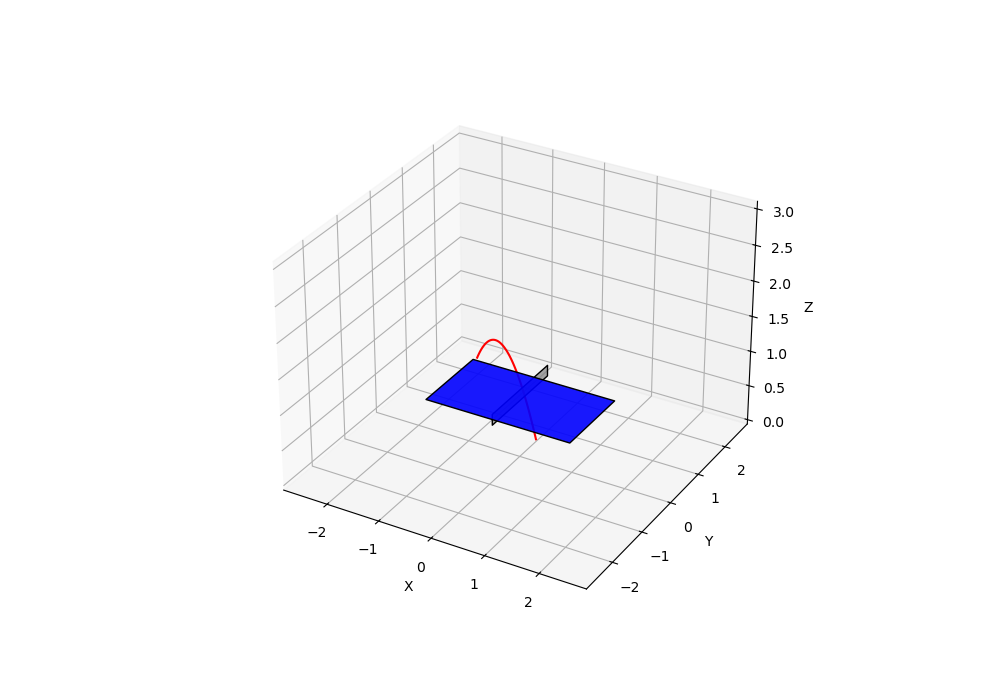

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

plot3D.plot_table(ax, table)
plot3D.plot_trajectory(ax, np.array(true_trajectory)[:, :3])
ax.set_xlim3d(-table.length/1, table.length/1)
ax.set_ylim3d(-table.length/1, table.length/1)
ax.set_zlim3d(0, table.height * 4)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

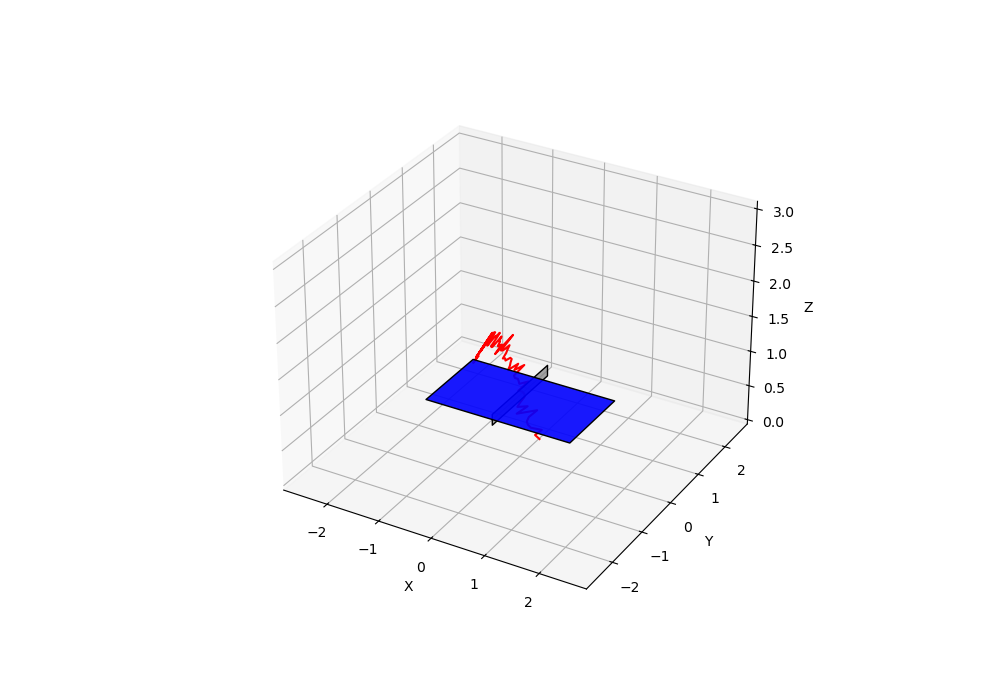

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

plot3D.plot_table(ax, table)
plot3D.plot_trajectory(ax, np.array(noisy_trajectory))
ax.set_xlim3d(-table.length/1, table.length/1)
ax.set_ylim3d(-table.length/1, table.length/1)
ax.set_zlim3d(0, table.height * 4)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

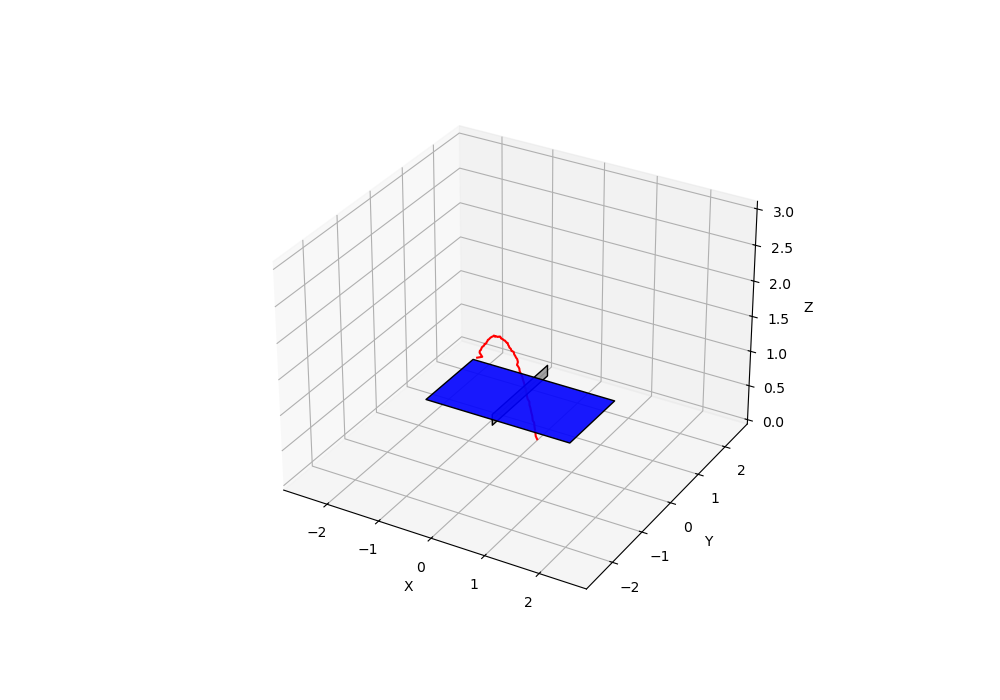

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

plot3D.plot_table(ax, table)
plot3D.plot_trajectory(ax, np.array(ukf_filtered_trajectory)[:,:3])
ax.set_xlim3d(-table.length/1, table.length/1)
ax.set_ylim3d(-table.length/1, table.length/1)
ax.set_zlim3d(0, table.height * 4)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()